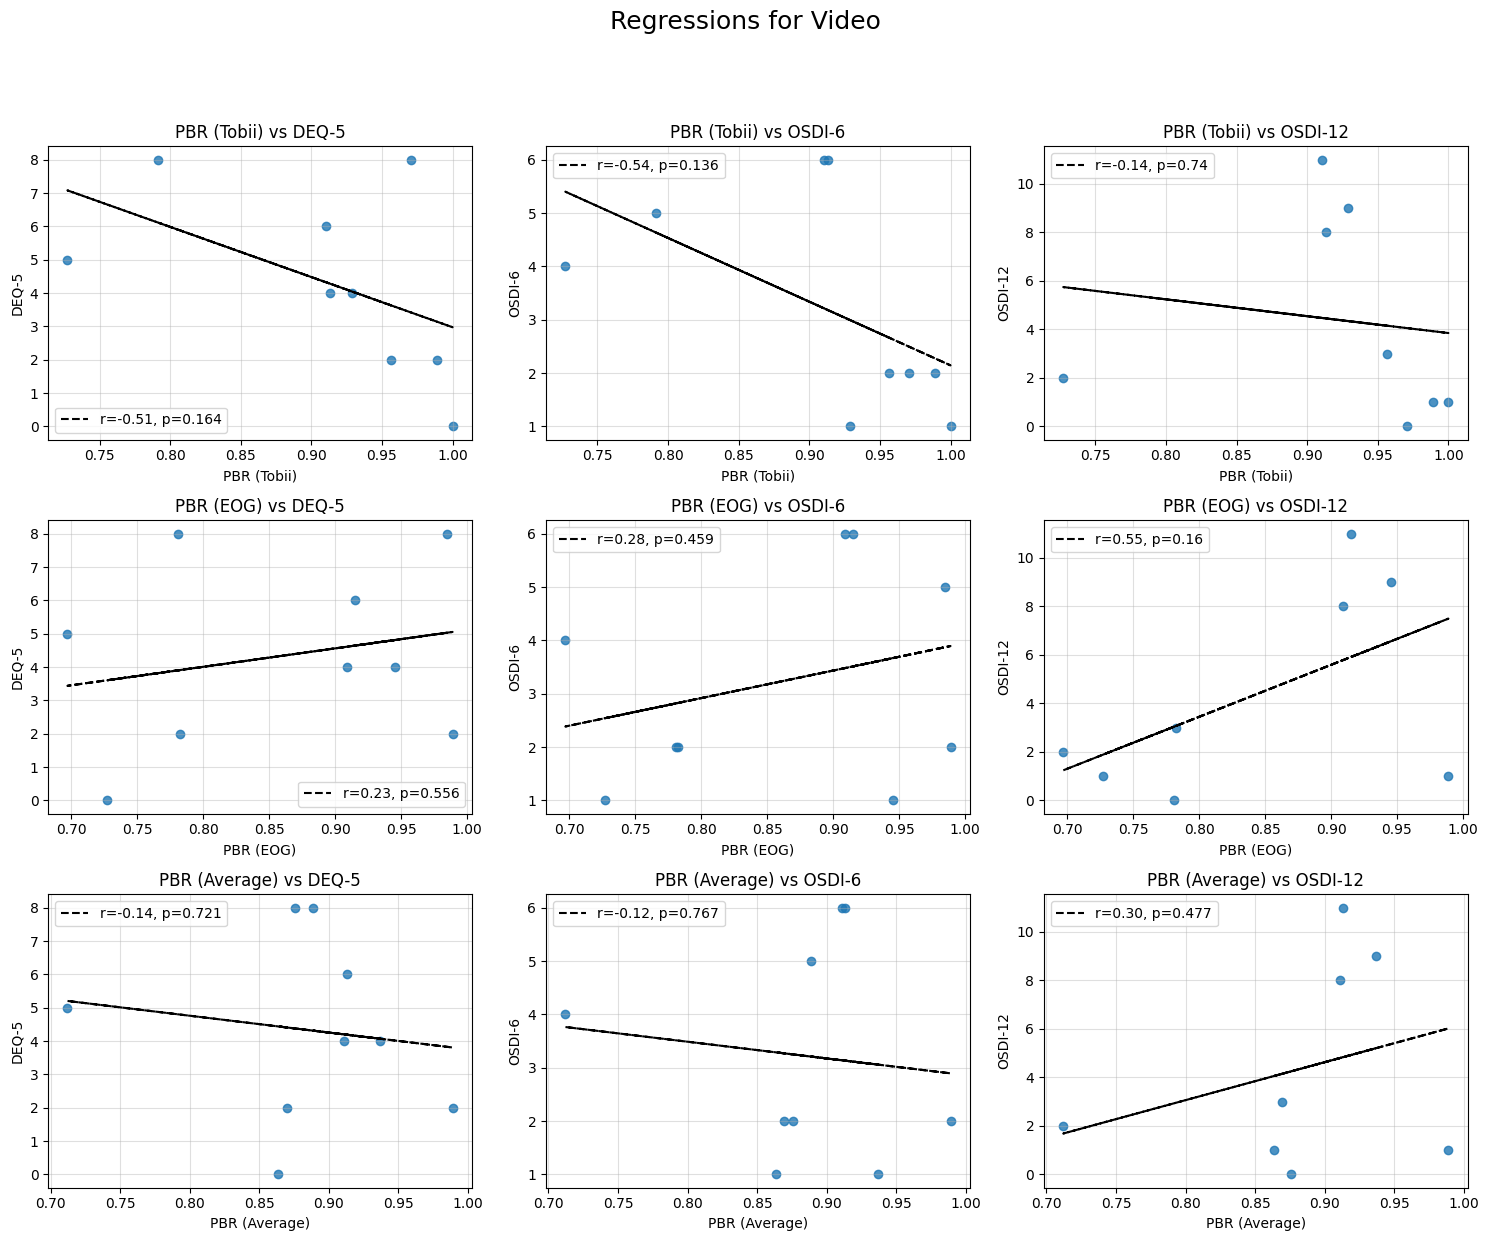

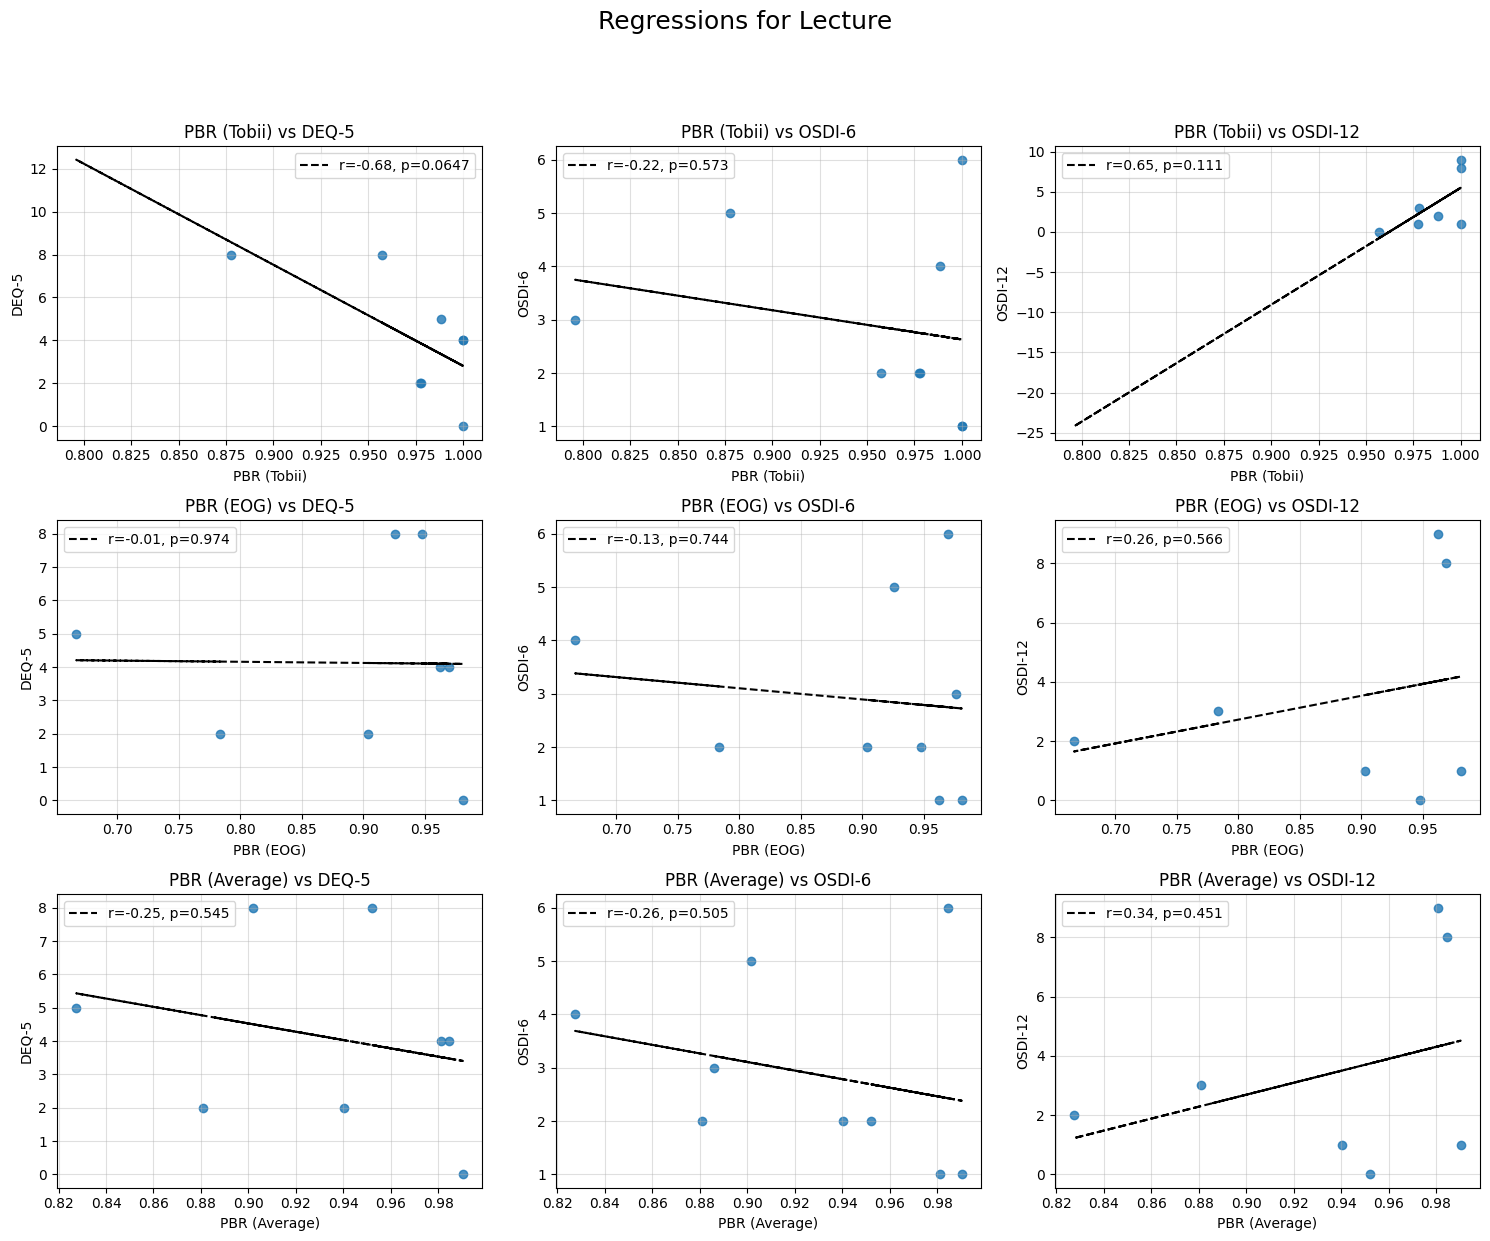

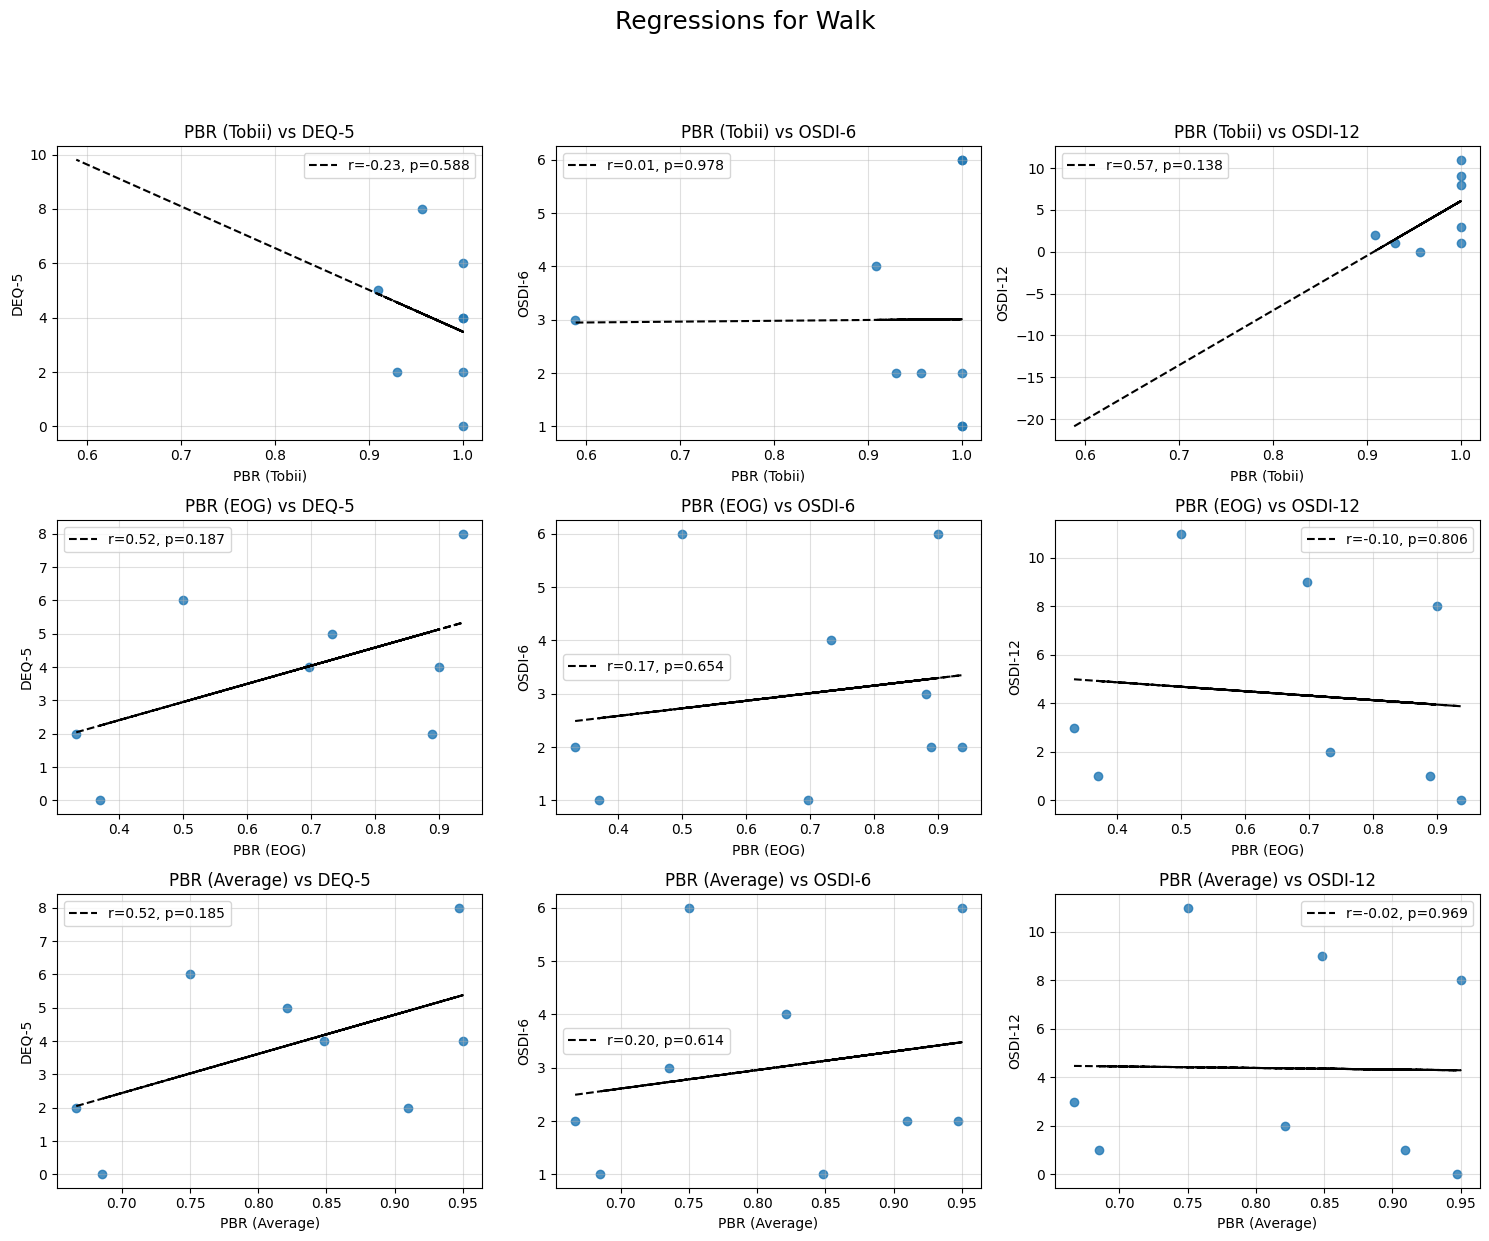

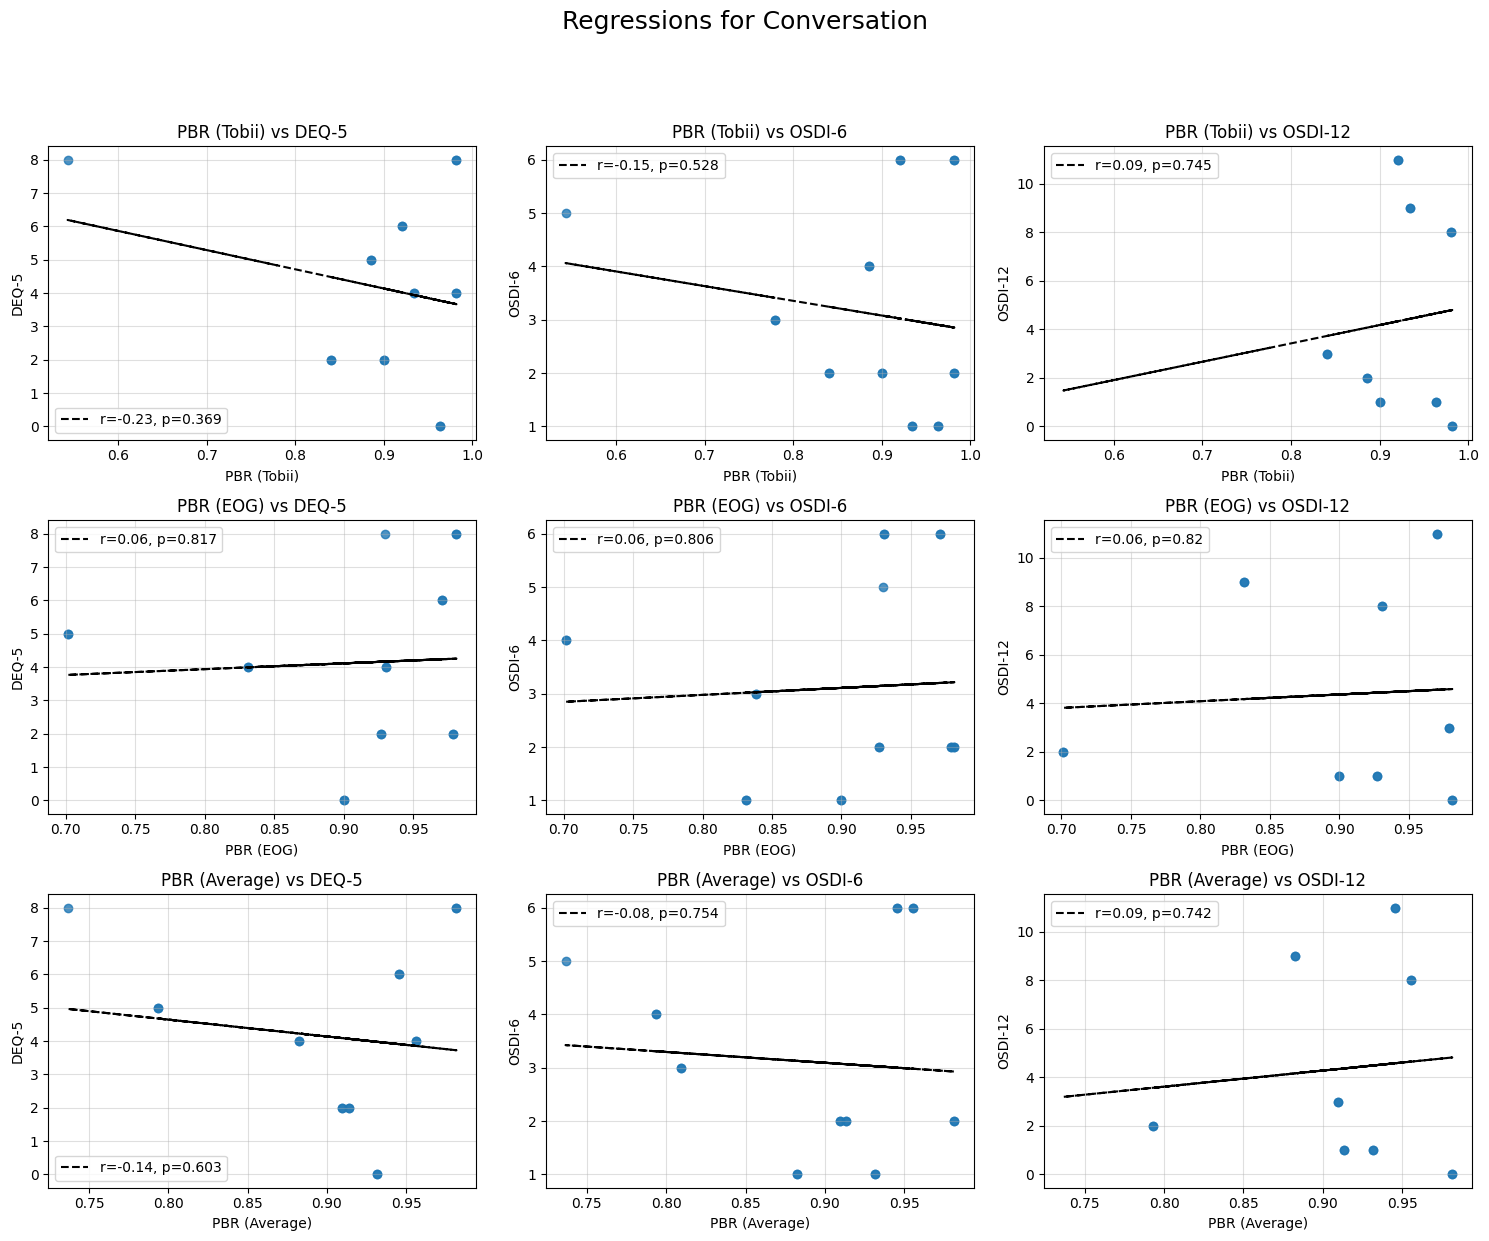

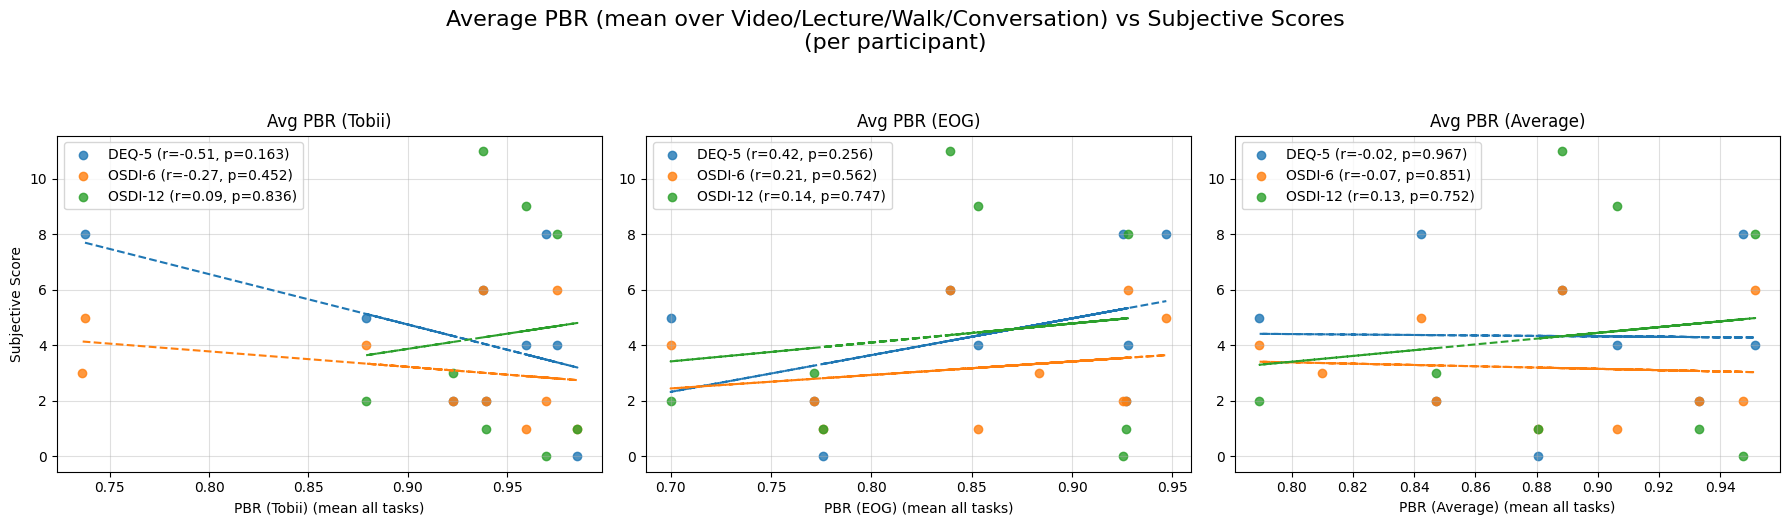

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pathlib import Path
import numpy as np
import re

# === Load Data ===
pbr_file = Path(r"C:/Users/yuz/Documents/Test_LOOK/partial_blink_rate_analysis.xlsx")
info_file = Path(r"C:/Users/yuz/Documents/Test_LOOK/Test LOOK Participant.xlsx")
mbi_file = Path(r"C:/Users/yuz/Documents/Test_LOOK/blink_MBI_analysis_summary.xlsx")

df_pbr = pd.read_excel(pbr_file)
df_info = pd.read_excel(info_file)
df_mbi = pd.read_excel(mbi_file)

# === Clean Column Names ===
df_info.columns = df_info.columns.str.strip()
df_pbr.columns = df_pbr.columns.str.strip()

# === Extract Participant and Task (including Conversation) ===
# Regex now matches 'video', 'lecture', 'walk', or 'conversation' (case-insensitive)
task_regex = r'_(video|Lecture|Walk|Conversation)'
df_pbr['Participant'] = df_pbr['Task_ID'].str.extract(r'(\d{2}_EB)')
df_pbr['Task'] = df_pbr['Task_ID'].str.extract(task_regex, flags=re.IGNORECASE)[0].str.capitalize()
df_pbr = df_pbr[df_pbr['Task'].isin(['Video', 'Lecture', 'Walk', 'Conversation'])]

df_mbi['Participant'] = df_mbi['Task_ID'].str.extract(r'(\d{2}_EB)')
df_mbi['Task'] = df_mbi['Task_ID'].str.extract(task_regex, flags=re.IGNORECASE)[0].str.capitalize()
df_mbi = df_mbi[df_mbi['Task'].isin(['Video', 'Lecture', 'Walk', 'Conversation'])]

mbi_col = [c for c in df_mbi.columns if 'MBI' in c and 'Longest' in c][0]
df_mbi['MBI'] = df_mbi[mbi_col].astype(str).str.replace(',', '.').astype(float)

for col in ['OSDI-6', 'OSDI-12', 'DEQ-5']:
    if col not in df_info.columns:
        print(f"Warning: {col} not found in participant info!")

df_info['Participant'] = df_info['numéro'].apply(lambda n: f"{int(n):02d}_EB")

# === Merge All Info ===
df_merged = pd.merge(df_pbr, df_mbi[['Participant','Task','MBI']], on=['Participant', 'Task'], how='left')
df_merged = pd.merge(df_merged, df_info[['Participant', 'OSDI-6', 'OSDI-12', 'DEQ-5']], on='Participant', how='left')

# === Add Average PBR Column ===
df_merged["Partial Blink Rate (Average)"] = df_merged[["Partial Blink Rate (Tobii)", "Partial Blink Rate (EOG)"]].mean(axis=1)

# === Parameters for Plotting ===
pbr_cols = [
    ("Partial Blink Rate (Tobii)", "PBR (Tobii)"),
    ("Partial Blink Rate (EOG)", "PBR (EOG)"),
    ("Partial Blink Rate (Average)", "PBR (Average)")
]
y_cols = [
    ("DEQ-5", "DEQ-5", "tab:blue"),
    ("OSDI-6", "OSDI-6", "tab:orange"),
    ("OSDI-12", "OSDI-12", "tab:green"),
]

def regression_subplot(ax, x, y, xlabel, ylabel, title):
    mask = x.notna() & y.notna()
    if mask.sum() < 3:
        ax.text(0.5, 0.5, "Not enough data", transform=ax.transAxes,
                ha='center', va='center', fontsize=10, color='gray')
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return
    slope, intercept, r, p, std_err = linregress(x[mask], y[mask])
    ax.scatter(x, y, alpha=0.8)
    ax.plot(x, slope * x + intercept, 'k--', label=f"r={r:.2f}, p={p:.3g}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.4)

# === Subplots by Task ===
for task in ["Video", "Lecture", "Walk", "Conversation"]:
    df_task = df_merged[df_merged["Task"] == task]
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle(f"Regressions for {task}", fontsize=18, y=1.03)
    for i, (pbr_col, pbr_label) in enumerate(pbr_cols):
        for j, (y_col, y_label, _) in enumerate(y_cols):
            ax = axes[i, j]
            x = df_task[pbr_col]
            y = df_task[y_col]
            title = f"{pbr_label} vs {y_label}"
            regression_subplot(ax, x, y, xlabel=pbr_label, ylabel=y_label, title=title)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# === 3-in-1 Summary Figure: Average PBR (mean over all tasks per participant) ===
df_avg = df_merged.groupby('Participant').agg({
    'Partial Blink Rate (Tobii)': 'mean',
    'Partial Blink Rate (EOG)': 'mean',
    'Partial Blink Rate (Average)': 'mean',
    'DEQ-5': 'first',
    'OSDI-6': 'first',
    'OSDI-12': 'first'
}).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
summary_titles = ["PBR (Tobii)", "PBR (EOG)", "PBR (Average)"]

for i, (pbr_col, pbr_label) in enumerate(pbr_cols):
    ax = axes[i]
    for y_col, y_label, color in y_cols:
        mask = df_avg[pbr_col].notna() & df_avg[y_col].notna()
        if mask.sum() < 3:
            ax.text(0.5, 0.5, f"Not enough data for {y_label}", transform=ax.transAxes,
                    ha='center', va='center', color=color, fontsize=10)
            continue
        x = df_avg.loc[mask, pbr_col]
        y = df_avg.loc[mask, y_col]
        slope, intercept, r, p, std_err = linregress(x, y)
        ax.scatter(x, y, label=f"{y_label} (r={r:.2f}, p={p:.3g})", color=color, alpha=0.8)
        ax.plot(x, slope * x + intercept, '--', color=color)
    ax.set_xlabel(f"{pbr_label} (mean all tasks)")
    if i == 0:
        ax.set_ylabel("Subjective Score")
    ax.set_title(f"Avg {pbr_label}")
    ax.legend()
    ax.grid(alpha=0.4)

fig.suptitle("Average PBR (mean over Video/Lecture/Walk/Conversation) vs Subjective Scores\n(per participant)", fontsize=16, y=1.04)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
